In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

# Importing the data

In [50]:
#define paths
p = os.getcwd()
parent = os.path.dirname(p)
relative = "/Exp 10/data/"
path = parent+relative
fileExt = ".txt"
# list the name of the files in the current folder
files = os.listdir(path)
DATA = []
for file in files:
    if file.endswith(fileExt):
        print(file)
        # Load the JSON data from the text file
        with open(path+file, "r") as f:
            json_data = json.load(f)
        # Create a DataFrame from the JSON data
        DATA.append([pd.DataFrame(json_data[cName]) for cName in json_data.keys()])
print(DATA[0][0].columns)

jatos_results_data_20230406145455.txt
jatos_results_data_20230406145542.txt
Index(['ID_name', 'block', 'color', 'condition', 'correct_keyboard_response',
       'number', 'practice', 'response_keyboard_response',
       'response_time_keyboard_response', 'subject_nr'],
      dtype='object')


# Looking at the training trials

Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot


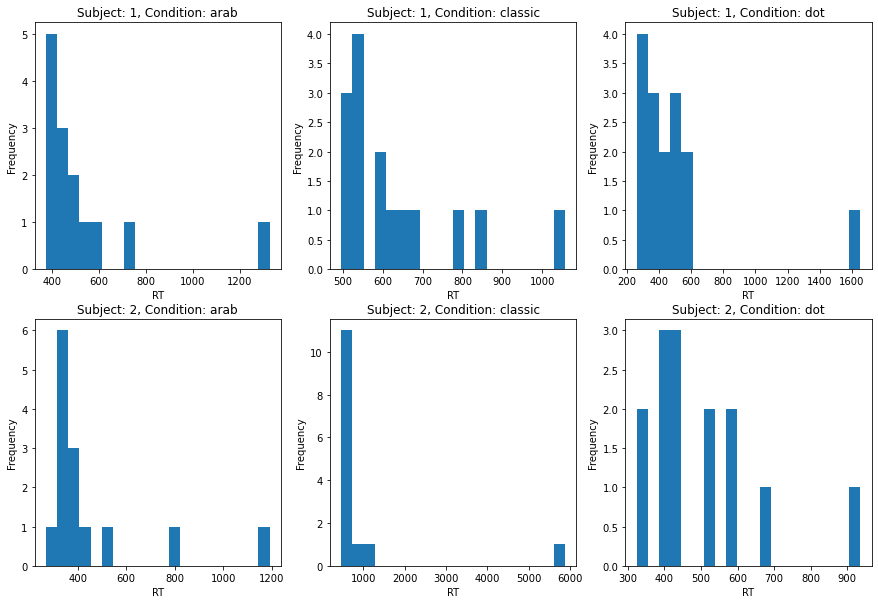

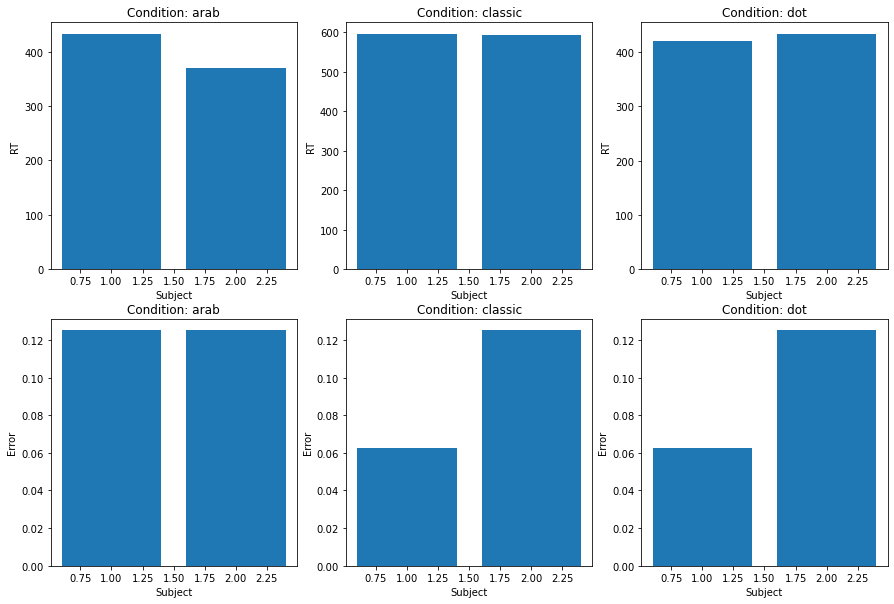

In [51]:
condType = np.unique(DATA[0][0]['condition'])
respType = np.unique(DATA[0][0]['response_keyboard_response'])
n,m = len(DATA), len(condType)
# saving the results for RT and Errors
practice_results = np.zeros((n, m, 2))
# plot the results
figRT, axRT = plt.subplots(n, m, figsize=(m*5,n*5))
axRT = axRT.flatten()
# looping over the subjects
for di, data in enumerate(DATA):
    data = data[0]
    practice_data = data[data['practice'] == "yes"]
    condType = np.unique(data['condition'])
    for ci, c in enumerate(condType):
        print("Condition: ", c)
        cdata = practice_data[practice_data['condition'] == c]
        # create an RT and an error table
        RT = cdata
        Err = cdata 
        # remove error trials from RT table
        RT = RT[RT['correct_keyboard_response'] == 1]
        # compute correct response
        practice_results[di,ci,0] = np.median(RT['response_time_keyboard_response'])
        practice_results[di,ci,1] = 1-np.mean(Err['correct_keyboard_response'])
        # plot the results
        axRT[di*m+ci].hist(RT['response_time_keyboard_response'], bins=20)
        axRT[di*m+ci].set_title("Subject: "+str(di+1)+", Condition: "+c)
        axRT[di*m+ci].set_xlabel("RT")
        axRT[di*m+ci].set_ylabel("Frequency")
plt.show()

# plot the results
fig, ax = plt.subplots(2, m, figsize=(m*5,2*5))
ax = ax.flatten()
for ci, c in enumerate(condType):
    ax[ci].bar(np.arange(n)+1, practice_results[:,ci,0])
    ax[ci].set_title("Condition: "+c)
    ax[ci].set_xlabel("Subject")
    ax[ci].set_ylabel("RT")
    ax[ci+m].bar(np.arange(n)+1, practice_results[:,ci,1])
    ax[ci+m].set_title("Condition: "+c)
    ax[ci+m].set_xlabel("Subject")
    ax[ci+m].set_ylabel("Error")
plt.show()

        


# Excluding subjects with high error rates

,ID_name,block,color,condition,correct_keyboard_response,number,practice,response_keyboard_response,response_time_keyboard_response,subject_nr
16,gabor1,1,red,arab,1,1,no,lshift,350,1
17,gabor1,1,blue,arab,1,4,no,rshift,480,1
18,gabor1,1,red,arab,1,3,no,lshift,5137,1
19,gabor1,1,red,arab,1,1,no,lshift,383,1
20,gabor1,1,red,arab,1,8,no,lshift,362,1


Condition:  arab
Condition:  classic
Condition:  dot


,ID_name,block,color,condition,correct_keyboard_response,number,practice,response_keyboard_response,response_time_keyboard_response,subject_nr
16,gabor2,1,blue,dot,0,3,no,lshift,434,1
17,gabor2,1,red,dot,0,1,no,rshift,366,1
18,gabor2,1,blue,dot,0,1,no,lshift,420,1
19,gabor2,1,red,dot,0,8,no,rshift,212,1
20,gabor2,1,red,dot,0,6,no,rshift,367,1


Condition:  arab
Condition:  classic
Condition:  dot
[[0.08541667 0.04910714 0.0875    ]
 [0.06666667 0.10714286 0.09375   ]]


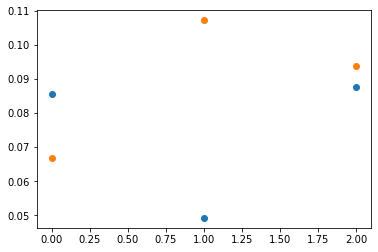

subjects excluded:  []
subjects included:  [0 1]
number of subjects:  2


In [52]:
ERR = np.zeros((len(DATA), len(condType)))
for di, data in enumerate(DATA):
    data = data[0]
    data = data[data['practice'] == "no"]
    display(data.head())
    for ci, c in enumerate(condType):
        print("Condition: ", c)
        cdata = data[data['condition'] == c]
        # summary stat on Errors
        ERR[di,ci] = 1-np.mean(cdata['correct_keyboard_response'])
print(ERR)
plt.plot(ERR.T, "o")
plt.show()
ix = np.unique(np.where(ERR>0.15)[0])
print("subjects excluded: ", ix)
# remaining subjects
ix = np.setdiff1d(np.arange(len(DATA)), ix)
DATA = [DATA[i] for i in ix]
print("subjects included: ", ix)
N = len(DATA)
print("number of subjects: ", N)


# Analyzing the SNARC effects in the three conditions

Condition:  arab


subject_nr                                     \
number                              1             2             3          
response_keyboard_response     lshift rshift lshift rshift lshift rshift   
ID_name                                                                    
gabor1                             22     28     28     25     26     26   

                                                                             \
number                          4             6             7             8   
response_keyboard_response lshift rshift lshift rshift lshift rshift lshift   
ID_name                                                                       
gabor1                         27     28     29     27     29     28     26   

                                                 
number                                 9         
response_keyboard_response rshift lshift rshift  
ID_name                                          
gabor1                         26     26     26

median                \
                           response_time_keyboard_response                 
number                                                   1             2   
response_keyboard_response                          lshift rshift lshift   
ID_name                                                                    
gabor1                                               404.0  426.0  429.5   

                                                                             \
                                                                              
number                                 3             4             6          
response_keyboard_response rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                       
gabor1                      443.0  424.5  396.5  440.0  450.5  447.0  396.0   

                                                                      
                                                                      
number                          7             8             9         
response_keyboard_response lshift rshift lshift rshift lshift rshift  
ID_name                                                               
gabor1                      439.0  413.0  428.0  396.5  414.5  452.0

subject_nr                                                   \
number                    1             2             3             4          
correct_response     lshift rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                        
gabor1                   27     29     29     29     28     28     29     29   

                                                                          
number                6             7             8             9         
correct_response lshift rshift lshift rshift lshift rshift lshift rshift  
ID_name                                                                   
gabor1               30     29     30     30     29     29     29     28

mean                                                    \
                     error                                                     
number                   1                   2                   3             
correct_response    lshift    rshift    lshift    rshift    lshift    rshift   
ID_name                                                                        
gabor1            0.185185  0.034483  0.034483  0.137931  0.071429  0.071429   

                                                                              \
                                                                               
number                   4                   6                   7             
correct_response    lshift    rshift    lshift    rshift    lshift    rshift   
ID_name                                                                        
gabor1            0.068966  0.034483  0.033333  0.068966  0.033333  0.066667   

                                                          
                                                          
number                   8                   9            
correct_response    lshift    rshift    lshift    rshift  
ID_name                                                   
gabor1            0.103448  0.103448  0.103448  0.071429

Condition:  classic


/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,0,:] = d_diff[0]
/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,1,:] = d_diff[1]


subject_nr                                     \
number                              1             2             3          
response_keyboard_response     lshift rshift lshift rshift lshift rshift   
ID_name                                                                    
gabor1                             14     12     12     11     13     13   

                                                                             \
number                          4             6             7             8   
response_keyboard_response lshift rshift lshift rshift lshift rshift lshift   
ID_name                                                                       
gabor1                         14     14     14     14     13     14     14   

                                                 
number                                 9         
response_keyboard_response rshift lshift rshift  
ID_name                                          
gabor1                         14     12     13

median                \
                           response_time_keyboard_response                 
number                                                   1             2   
response_keyboard_response                          lshift rshift lshift   
ID_name                                                                    
gabor1                                               530.0  539.5  554.5   

                                                                             \
                                                                              
number                                 3             4             6          
response_keyboard_response rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                       
gabor1                      602.0  614.0  525.0  564.5  585.0  588.5  541.0   

                                                                      
                                                                      
number                          7             8             9         
response_keyboard_response lshift rshift lshift rshift lshift rshift  
ID_name                                                               
gabor1                      608.0  642.0  557.0  535.0  593.5  505.0

subject_nr                                                   \
number                    1             2             3             4          
correct_response     lshift rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                        
gabor1                   14     14     13     14     14     14     14     14   

                                                                          
number                6             7             8             9         
correct_response lshift rshift lshift rshift lshift rshift lshift rshift  
ID_name                                                                   
gabor1               14     14     14     14     14     14     14     13

mean                                                    \
                  error                                                     
number                1                   2                   3             
correct_response lshift    rshift    lshift    rshift    lshift    rshift   
ID_name                                                                     
gabor1              0.0  0.142857  0.076923  0.214286  0.071429  0.071429   

                                                                             \
                                                                              
number                4             6                7             8          
correct_response lshift rshift lshift rshift    lshift rshift lshift rshift   
ID_name                                                                       
gabor1              0.0    0.0    0.0    0.0  0.071429    0.0    0.0    0.0   

                                   
                                   
number                   9         
correct_response    lshift rshift  
ID_name                            
gabor1            0.142857    0.0

Condition:  dot


/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,0,:] = d_diff[0]
/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,1,:] = d_diff[1]


subject_nr                                     \
number                              1             2             3          
response_keyboard_response     lshift rshift lshift rshift lshift rshift   
ID_name                                                                    
gabor1                             28     26     28     28     27     24   

                                                                             \
number                          4             6             7             8   
response_keyboard_response lshift rshift lshift rshift lshift rshift lshift   
ID_name                                                                       
gabor1                         25     28     28     28     24     25     26   

                                                 
number                                 9         
response_keyboard_response rshift lshift rshift  
ID_name                                          
gabor1                         29     30     28

median                \
                           response_time_keyboard_response                 
number                                                   1             2   
response_keyboard_response                          lshift rshift lshift   
ID_name                                                                    
gabor1                                               418.5  415.5  430.0   

                                                                             \
                                                                              
number                                 3             4             6          
response_keyboard_response rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                       
gabor1                      441.5  434.0  452.0  411.0  449.5  459.5  417.5   

                                                                      
                                                                      
number                          7             8             9         
response_keyboard_response lshift rshift lshift rshift lshift rshift  
ID_name                                                               
gabor1                      420.5  462.0  446.0  416.0  463.0  422.0

subject_nr                                                   \
number                    1             2             3             4          
correct_response     lshift rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                        
gabor1                   29     29     30     29     29     29     29     29   

                                                                          
number                6             7             8             9         
correct_response lshift rshift lshift rshift lshift rshift lshift rshift  
ID_name                                                                   
gabor1               30     30     29     29     30     30     30     30

mean                                                    \
                     error                                                     
number                   1                   2                   3             
correct_response    lshift    rshift    lshift    rshift    lshift    rshift   
ID_name                                                                        
gabor1            0.034483  0.103448  0.066667  0.034483  0.068966  0.172414   

                                                                              \
                                                                               
number                   4                   6                   7             
correct_response    lshift    rshift    lshift    rshift    lshift    rshift   
ID_name                                                                        
gabor1            0.137931  0.034483  0.066667  0.066667  0.172414  0.137931   

                                                       
                                                       
number                   8                9            
correct_response    lshift    rshift lshift    rshift  
ID_name                                                
gabor1            0.133333  0.033333    0.0  0.066667

Condition:  arab


/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,0,:] = d_diff[0]
/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,1,:] = d_diff[1]


subject_nr                                     \
number                              1             2             3          
response_keyboard_response     lshift rshift lshift rshift lshift rshift   
ID_name                                                                    
gabor2                             27     28     27     25     26     27   

                                                                             \
number                          4             6             7             8   
response_keyboard_response lshift rshift lshift rshift lshift rshift lshift   
ID_name                                                                       
gabor2                         27     27     23     27     29     26     25   

                                                 
number                                 9         
response_keyboard_response rshift lshift rshift  
ID_name                                          
gabor2                         26     27     27

median                \
                           response_time_keyboard_response                 
number                                                   1             2   
response_keyboard_response                          lshift rshift lshift   
ID_name                                                                    
gabor2                                               414.0  462.0  474.0   

                                                                             \
                                                                              
number                                 3             4             6          
response_keyboard_response rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                       
gabor2                      443.0  405.5  420.0  435.0  421.0  423.0  459.0   

                                                                      
                                                                      
number                          7             8             9         
response_keyboard_response lshift rshift lshift rshift lshift rshift  
ID_name                                                               
gabor2                      434.0  408.0  439.0  437.0  428.0  411.0

subject_nr                                                   \
number                    1             2             3             4          
correct_response     lshift rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                        
gabor2                   27     30     29     28     29     29     30     28   

                                                                          
number                6             7             8             9         
correct_response lshift rshift lshift rshift lshift rshift lshift rshift  
ID_name                                                                   
gabor2               28     29     29     27     26     27     30     28

mean                                                    \
                  error                                                     
number                1                   2                   3             
correct_response lshift    rshift    lshift    rshift    lshift    rshift   
ID_name                                                                     
gabor2              0.0  0.066667  0.068966  0.107143  0.103448  0.068966   

                                                                        \
                                                                         
number                4                   6                7             
correct_response lshift    rshift    lshift    rshift lshift    rshift   
ID_name                                                                  
gabor2              0.1  0.035714  0.178571  0.068966    0.0  0.037037   

                                                       
                                                       
number                   8                9            
correct_response    lshift    rshift lshift    rshift  
ID_name                                                
gabor2            0.038462  0.037037    0.1  0.035714

Condition:  classic


/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,0,:] = d_diff[0]
/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,1,:] = d_diff[1]


subject_nr                                     \
number                              1             2             3          
response_keyboard_response     lshift rshift lshift rshift lshift rshift   
ID_name                                                                    
gabor2                             13     13     10     14     14     11   

                                                                             \
number                          4             6             7             8   
response_keyboard_response lshift rshift lshift rshift lshift rshift lshift   
ID_name                                                                       
gabor2                         13     14     10     13     14      9     11   

                                                 
number                                 9         
response_keyboard_response rshift lshift rshift  
ID_name                                          
gabor2                         14     13     12

median                \
                           response_time_keyboard_response                 
number                                                   1             2   
response_keyboard_response                          lshift rshift lshift   
ID_name                                                                    
gabor2                                               547.0  646.0  605.5   

                                                                             \
                                                                              
number                                 3             4             6          
response_keyboard_response rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                       
gabor2                      712.0  672.5  490.0  631.0  559.5  588.5  591.0   

                                                                      
                                                                      
number                          7             8             9         
response_keyboard_response lshift rshift lshift rshift lshift rshift  
ID_name                                                               
gabor2                      557.5  588.0  514.0  591.5  614.0  616.0

subject_nr                                                   \
number                    1             2             3             4          
correct_response     lshift rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                        
gabor2                   14     13     13     14     14     14     14     14   

                                                                          
number                6             7             8             9         
correct_response lshift rshift lshift rshift lshift rshift lshift rshift  
ID_name                                                                   
gabor2               14     14     14     13     13     14     14     14

mean                                                     \
                     error                                                      
number                   1                2             3                   4   
correct_response    lshift rshift    lshift rshift lshift    rshift    lshift   
ID_name                                                                         
gabor2            0.071429    0.0  0.230769    0.0    0.0  0.214286  0.071429   

                                                                               \
                                                                                
number                          6                7                   8          
correct_response rshift    lshift    rshift lshift    rshift    lshift rshift   
ID_name                                                                         
gabor2              0.0  0.285714  0.071429    0.0  0.307692  0.153846    0.0   

                                      
                                      
number                   9            
correct_response    lshift    rshift  
ID_name                               
gabor2            0.071429  0.142857

Condition:  dot


/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,0,:] = d_diff[0]
/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,1,:] = d_diff[1]


subject_nr                                     \
number                              1             2             3          
response_keyboard_response     lshift rshift lshift rshift lshift rshift   
ID_name                                                                    
gabor2                             24     25     28     28     25     26   

                                                                             \
number                          4             6             7             8   
response_keyboard_response lshift rshift lshift rshift lshift rshift lshift   
ID_name                                                                       
gabor2                         29     27     25     28     28     28     26   

                                                 
number                                 9         
response_keyboard_response rshift lshift rshift  
ID_name                                          
gabor2                         30     25     29

median                \
                           response_time_keyboard_response                 
number                                                   1             2   
response_keyboard_response                          lshift rshift lshift   
ID_name                                                                    
gabor2                                               429.5  415.0  422.5   

                                                                             \
                                                                              
number                                 3             4             6          
response_keyboard_response rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                       
gabor2                      430.0  424.0  370.0  404.0  441.0  445.0  389.5   

                                                                      
                                                                      
number                          7             8             9         
response_keyboard_response lshift rshift lshift rshift lshift rshift  
ID_name                                                               
gabor2                      423.5  411.5  426.5  419.0  394.0  392.0

subject_nr                                                   \
number                    1             2             3             4          
correct_response     lshift rshift lshift rshift lshift rshift lshift rshift   
ID_name                                                                        
gabor2                   30     30     29     29     30     30     30     30   

                                                                          
number                6             7             8             9         
correct_response lshift rshift lshift rshift lshift rshift lshift rshift  
ID_name                                                                   
gabor2               28     30     30     30     30     30     29     30

mean                                                    \
                  error                                                     
number                1                   2                   3             
correct_response lshift    rshift    lshift    rshift    lshift    rshift   
ID_name                                                                     
gabor2              0.2  0.166667  0.034483  0.034483  0.166667  0.133333   

                                                                           \
                                                                            
number                   4                6                   7             
correct_response    lshift rshift    lshift    rshift    lshift    rshift   
ID_name                                                                     
gabor2            0.033333    0.1  0.107143  0.066667  0.066667  0.066667   

                                                       
                                                       
number                   8                9            
correct_response    lshift rshift    lshift    rshift  
ID_name                                                
gabor2            0.133333    0.0  0.137931  0.033333

/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,0,:] = d_diff[0]
/var/folders/7v/b8fs48v95fxb7gdt_3bqj7q00000gp/T/ipykernel_57367/1949133218.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  main_results_diff[di,ci,1,:] = d_diff[1]


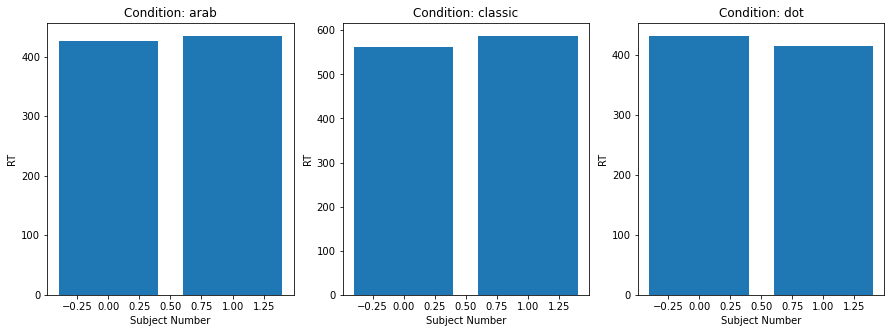

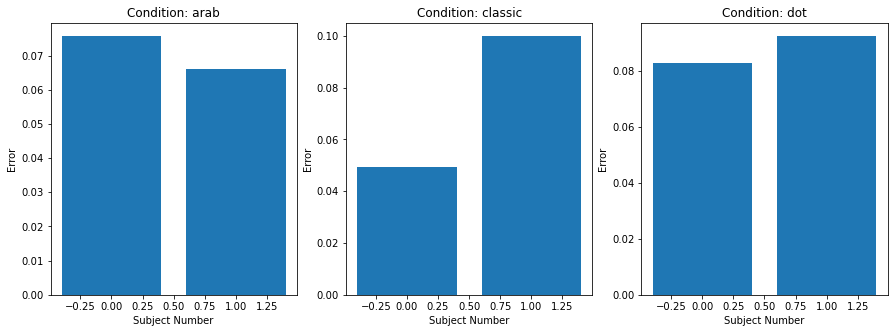

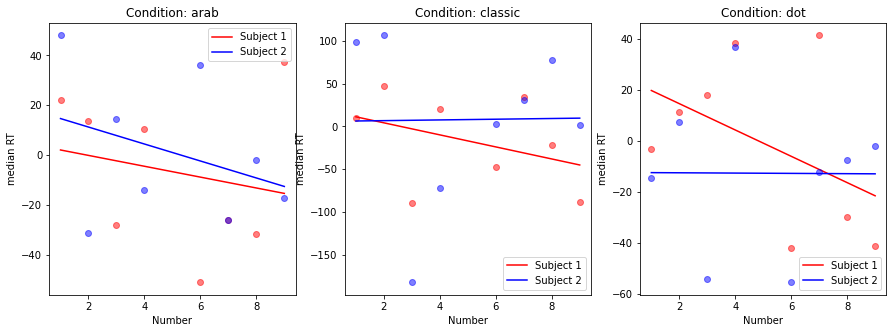

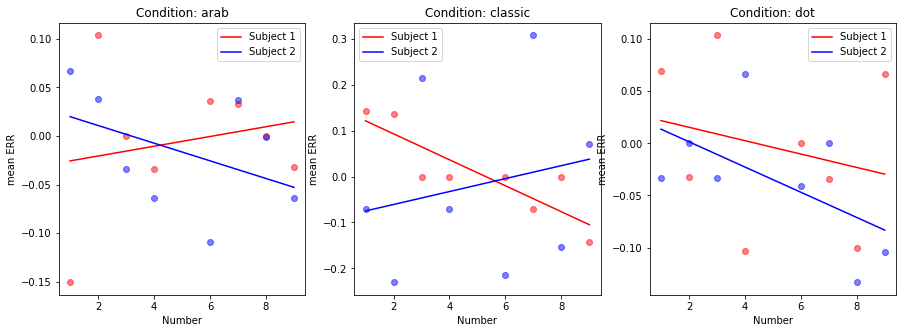

In [78]:
# predictiors for the regression
Xs = np.unique(data['number'])
xT = np.stack((np.ones(len(Xs)), Xs), axis=-1)
# saving the results for RT and Errors
main_results = np.zeros((len(DATA), len(condType), 6))
main_results_diff = np.zeros((len(DATA), len(condType), 2, 8))
# looping over the subjects
for di, data in enumerate(DATA):
    data = data[0]
    # removing the training trials
    data = data[data['practice'] == "no"]
    #display(data.head())
    # deleting very long and very short responses
    # plotting the data before
    data = data[(data['response_time_keyboard_response']>200) & (data['response_time_keyboard_response']<2000)]
    # splitting the data into three conditions
    for ci, c in enumerate(condType):
        print("Condition: ", c)
        cdata = data[data['condition'] == c]
        # create an RT and an error table
        RT = cdata
        Err = cdata 
        # remove error trials from RT table
        RT = RT[RT['correct_keyboard_response'] == 1]
        # create a pivot table to get the median of the response times for each numbers
        pivotRT_count = pd.pivot_table(RT, index=['ID_name'], columns=['number','response_keyboard_response'], values=['subject_nr'], aggfunc='count')
        display(pivotRT_count)
        pivotRT = pd.pivot_table(RT, index=['ID_name'], columns=['number','response_keyboard_response'], values=['response_time_keyboard_response'], aggfunc=[np.median])
        display(pivotRT)
        # compute correct response
        correct_response = [t if c==1 else respType[respType!=t][0]
                            for c,t in zip(Err['correct_keyboard_response'], Err['response_keyboard_response'])]
        Err = Err.assign(correct_response=correct_response)
        error = [1-c for c in Err['correct_keyboard_response']]
        Err = Err.assign(error=error)
        #display(Err.head())
        # summary stat on Errors
        pivotErr_count = pd.pivot_table(Err, index=['ID_name'], columns=['number','correct_response'], values=['subject_nr'], aggfunc='count')
        display(pivotErr_count)
        pivotErr = pd.pivot_table(Err, index=['ID_name'], columns=['number','correct_response'], values=['error'], aggfunc=[np.mean])
        display(pivotErr)
        d_diff, d_reg = [], []
        for d in [pivotRT, pivotErr]:
            diff = [d.values[:, i+1] - d.values[:, i] for i in range(0, pivotErr.shape[1], 2)]
            d_diff.append(diff)
            # print(diff)
            # for i in range(0, pivotErr.shape[1], 2):
            #     print(i, d.values[:, i+1], d.values[:, i], d.values[:, i+1] - d.values[:, i])
            # fit linear regression on the differences
            d_reg.append(np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(xT),xT)),np.transpose(xT)), diff))
        main_results[di,ci,0] = np.median(RT['response_time_keyboard_response'])
        main_results[di,ci,1] = np.mean(Err['error'])
        main_results[di,ci,2] = d_reg[0][0]
        main_results[di,ci,3] = d_reg[0][1]
        main_results[di,ci,4] = d_reg[1][0]
        main_results[di,ci,5] = d_reg[1][1]
        main_results_diff[di,ci,0,:] = d_diff[0]
        main_results_diff[di,ci,1,:] = d_diff[1]

# plot the median RTs
X = np.arange(N)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ci, c in enumerate(condType):
    ax[ci].bar(X, main_results[:,ci,0])
    ax[ci].set_title("Condition: "+c)
    ax[ci].set_xlabel("Subject Number")
    ax[ci].set_ylabel("RT")
plt.show()
# plot the mean Errors
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ci, c in enumerate(condType):
    ax[ci].bar(X, main_results[:,ci,1])
    ax[ci].set_title("Condition: "+c)
    ax[ci].set_xlabel("Subject Number")
    ax[ci].set_ylabel("Error")
# plot the difference between the three conditions RTs
cols = ['r','b','g']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ci, c in enumerate(condType):
    for s in range(N):
        ax[ci].plot(Xs, main_results_diff[s,ci,0,:], "o", color=cols[s], alpha=0.5)
        ax[ci].plot(Xs, Xs*main_results[s,ci,3] + main_results[s,ci,2], "-", color=cols[s], label="Subject "+str(s+1))
    ax[ci].set_title("Condition: "+c)
    ax[ci].set_xlabel("Number")
    ax[ci].set_ylabel("median RT")
    ax[ci].legend()
plt.show()
# plot the difference between the three conditions ERRs
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ci, c in enumerate(condType):
    for s in range(N):
        ax[ci].plot(Xs, main_results_diff[s,ci,1,:], "o", color=cols[s], alpha=0.5)
        ax[ci].plot(Xs, Xs*main_results[s,ci,5] + main_results[s,ci,4], "-", color=cols[s], label="Subject "+str(s+1))
    ax[ci].set_title("Condition: "+c)
    ax[ci].set_xlabel("Number")
    ax[ci].set_ylabel("mean ERR")
    ax[ci].legend()
plt.show()